In [2]:
# imports, Python SQL toolkit and Object Relational Mapper
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Connect to the SQL DB
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
#Inspect the DB

inspector = inspect(engine)
inspector.get_table_names()

# table names are measurement and station

['measurement', 'station']

In [5]:
# Print a list of column names and types for the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Print a list of column names and types for the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# Reflect the measurement and station tables into classes
# Save a reference to the classes called: Measurement and Station
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(bind=engine)

# Precipitation Analysis

In [9]:
# Perform a query to retrieve the data and precipitation scores
Precipitation_stats = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_stats_table = pd.DataFrame(Precipitation_stats, columns=['station', 'date', 'prcp', 'tobs'])
Precipitation_stats_table.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65.0
1,USC00513117,2010-01-01,0.28,67.0
2,USC00518838,2010-01-01,0.21,72.0
3,USC00519523,2010-01-01,0.15,75.0
4,USC00519281,2010-01-01,0.15,70.0


In [10]:
# Calculate the date 1 year ago from the last data point in the database

Most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

Year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
Year_ago

datetime.date(2016, 8, 23)

In [11]:
# Query to retrieve the last 12 months of precipitation data and plot the results
Precipitation_last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

In [37]:
# Put the last 12 months of precipitation data into dataframe with date
# Utilize the date as the index and drop null values
Precipitation_data = pd.DataFrame(Precipitation_last_year, columns=['Date', 'Precipitation (inches)'])
Precipitation_data.set_index(Precipitation_data['Date'], inplace=True)
Precipitation_data = Precipitation_data.dropna()
Precipitation_data.head()

,Date,Precipitation (inches)
Date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,0.15
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.02
2016-08-23,2016-08-23,1.79


Text(0.5, -47.93000000000003, 'Date')

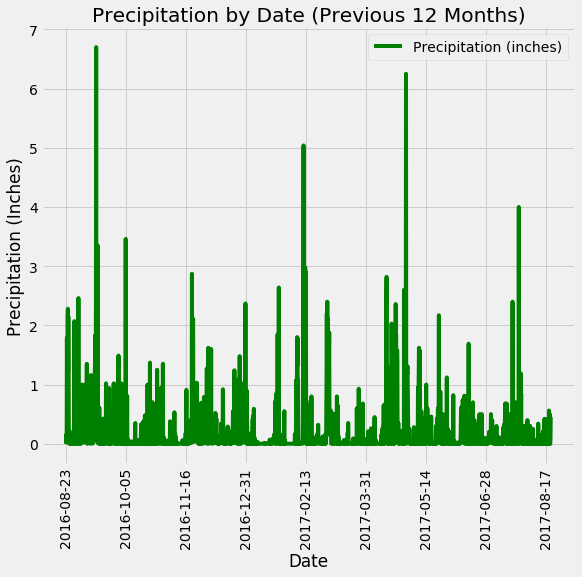

In [47]:
# Create a plot of the precipitation data for the past 12 months
color = 'green'
Precipitation_data.plot(kind='line', rot=90, color = color, figsize=(8,8))
plt.tight_layout()
Precipitation_plot.grid(True)
plt.title("Precipitation by Date (Previous 12 Months)")
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")

In [14]:
# Summary statistics for the Precipitation data
Precipitation_data.describe()

,Precipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [15]:
# Show the number of observation times at each station in the dataset
session.query(func.count(Measurement.station)).group_by(Measurement.station).all()

[(1979), (2709), (2202), (2612), (1372), (511), (2772), (2724), (2669)]

In [16]:
# Query to show how many stations are available in this dataset
session.query(Station.id).count()

9

In [17]:
# List the most active stations and the counts of observations in descending order
# Station 'USC00519281' has the most observations
Station_stats = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
Station_stats

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Calculate the lowest and highest temperature recorded, and average temperature of the most active station

Most_active_station = Station_stats[0][0]
session.query(func.min(Measurement.tobs), 
        func.avg(Measurement.tobs), 
        func.max(Measurement.tobs)).\
        filter(Measurement.station == Most_active_station).all()


[(54.0, 71.66378066378067, 85.0)]

In [19]:
# Query previous 12 months of temperature observation data from the station with the most number of temperature observations

Top_station_data = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == Most_active_station).\
    filter(Measurement.date > '2016-08-22').all()

# Create the dataframe
Top_Station_df = pd.DataFrame(Top_station_data)
Top_Station_df.set_index('station', inplace=True)
Top_Station_df.head()


,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


Text(0, 0.5, 'Frequency')

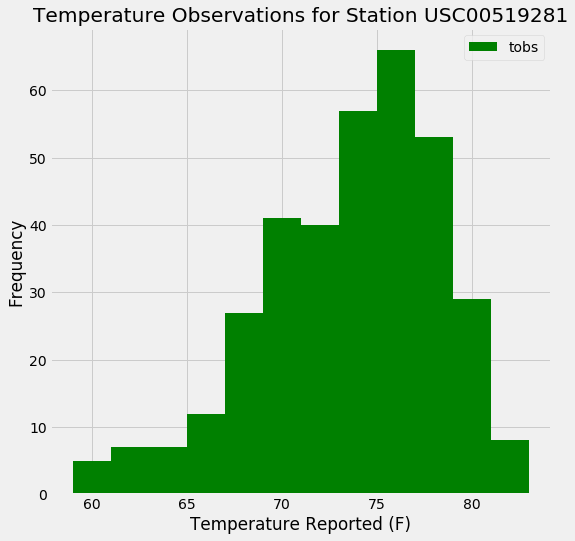

In [20]:
# plot the data into a histogram for Station USC00519281

color = 'green'
Top_Station_df.plot.hist(by='station', bins=12, color=color, figsize=(8,8))
plt.title("Temperature Observations for Station USC00519281")
plt.xlabel("Temperature Reported (F)")
plt.ylabel("Frequency")